<a href="https://colab.research.google.com/github/mukkatharun/advance-deep-learning-assignments/blob/main/Assignment5_Continual%20ML%20and%20Active%20Learning/active_learning_with_label_studio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 507 kB 14.3 MB/s 
     |████████████████████████████████| 798 kB 63.2 MB/s 
     |████████████████████████████████| 151 kB 70.1 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 117 kB 71.8 MB/s 
     |████████████████████████████████| 529 kB 39.5 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144576 sha256=dcf4b4c29eae9fe0c256c9cc50f705ed0eac9d64bb310a0c3b7e6b9e7da9c7a4
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=ec42f0e6bc86909a2dc7dd9d8d08edb56e781b1d5e6540f1418a1c93e0c12211
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e

In [ ]:
import warnings

Labelling the data in label studio

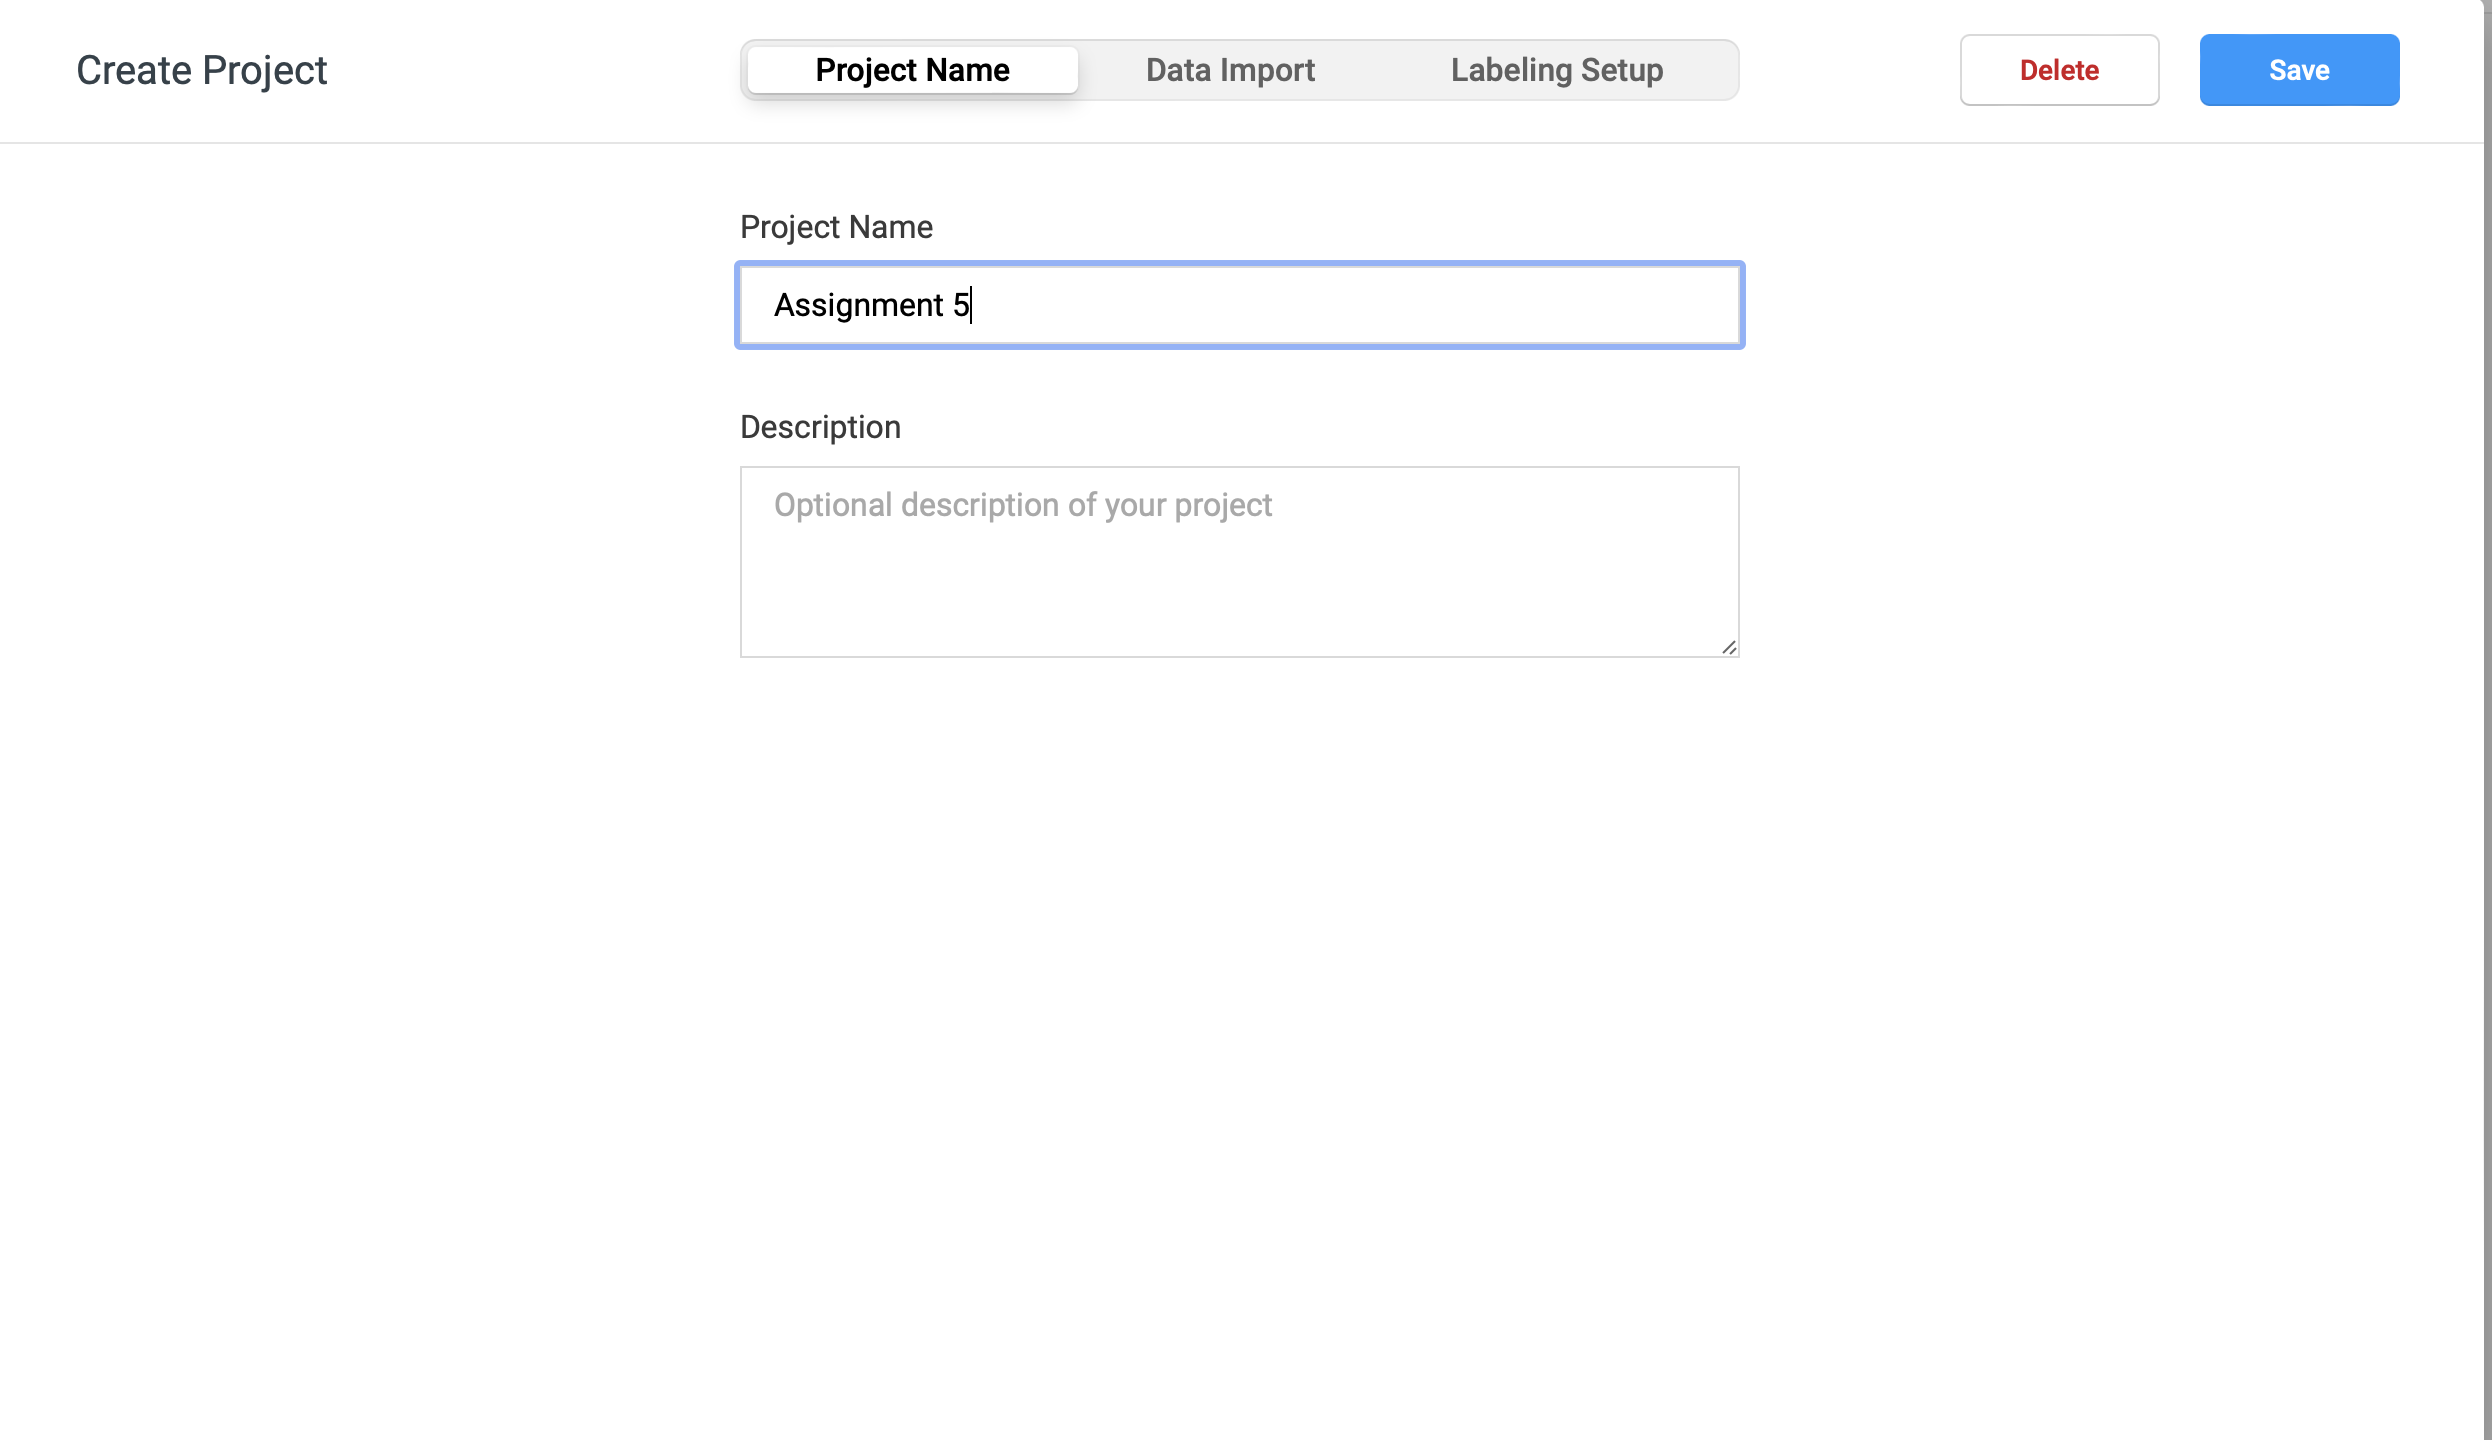

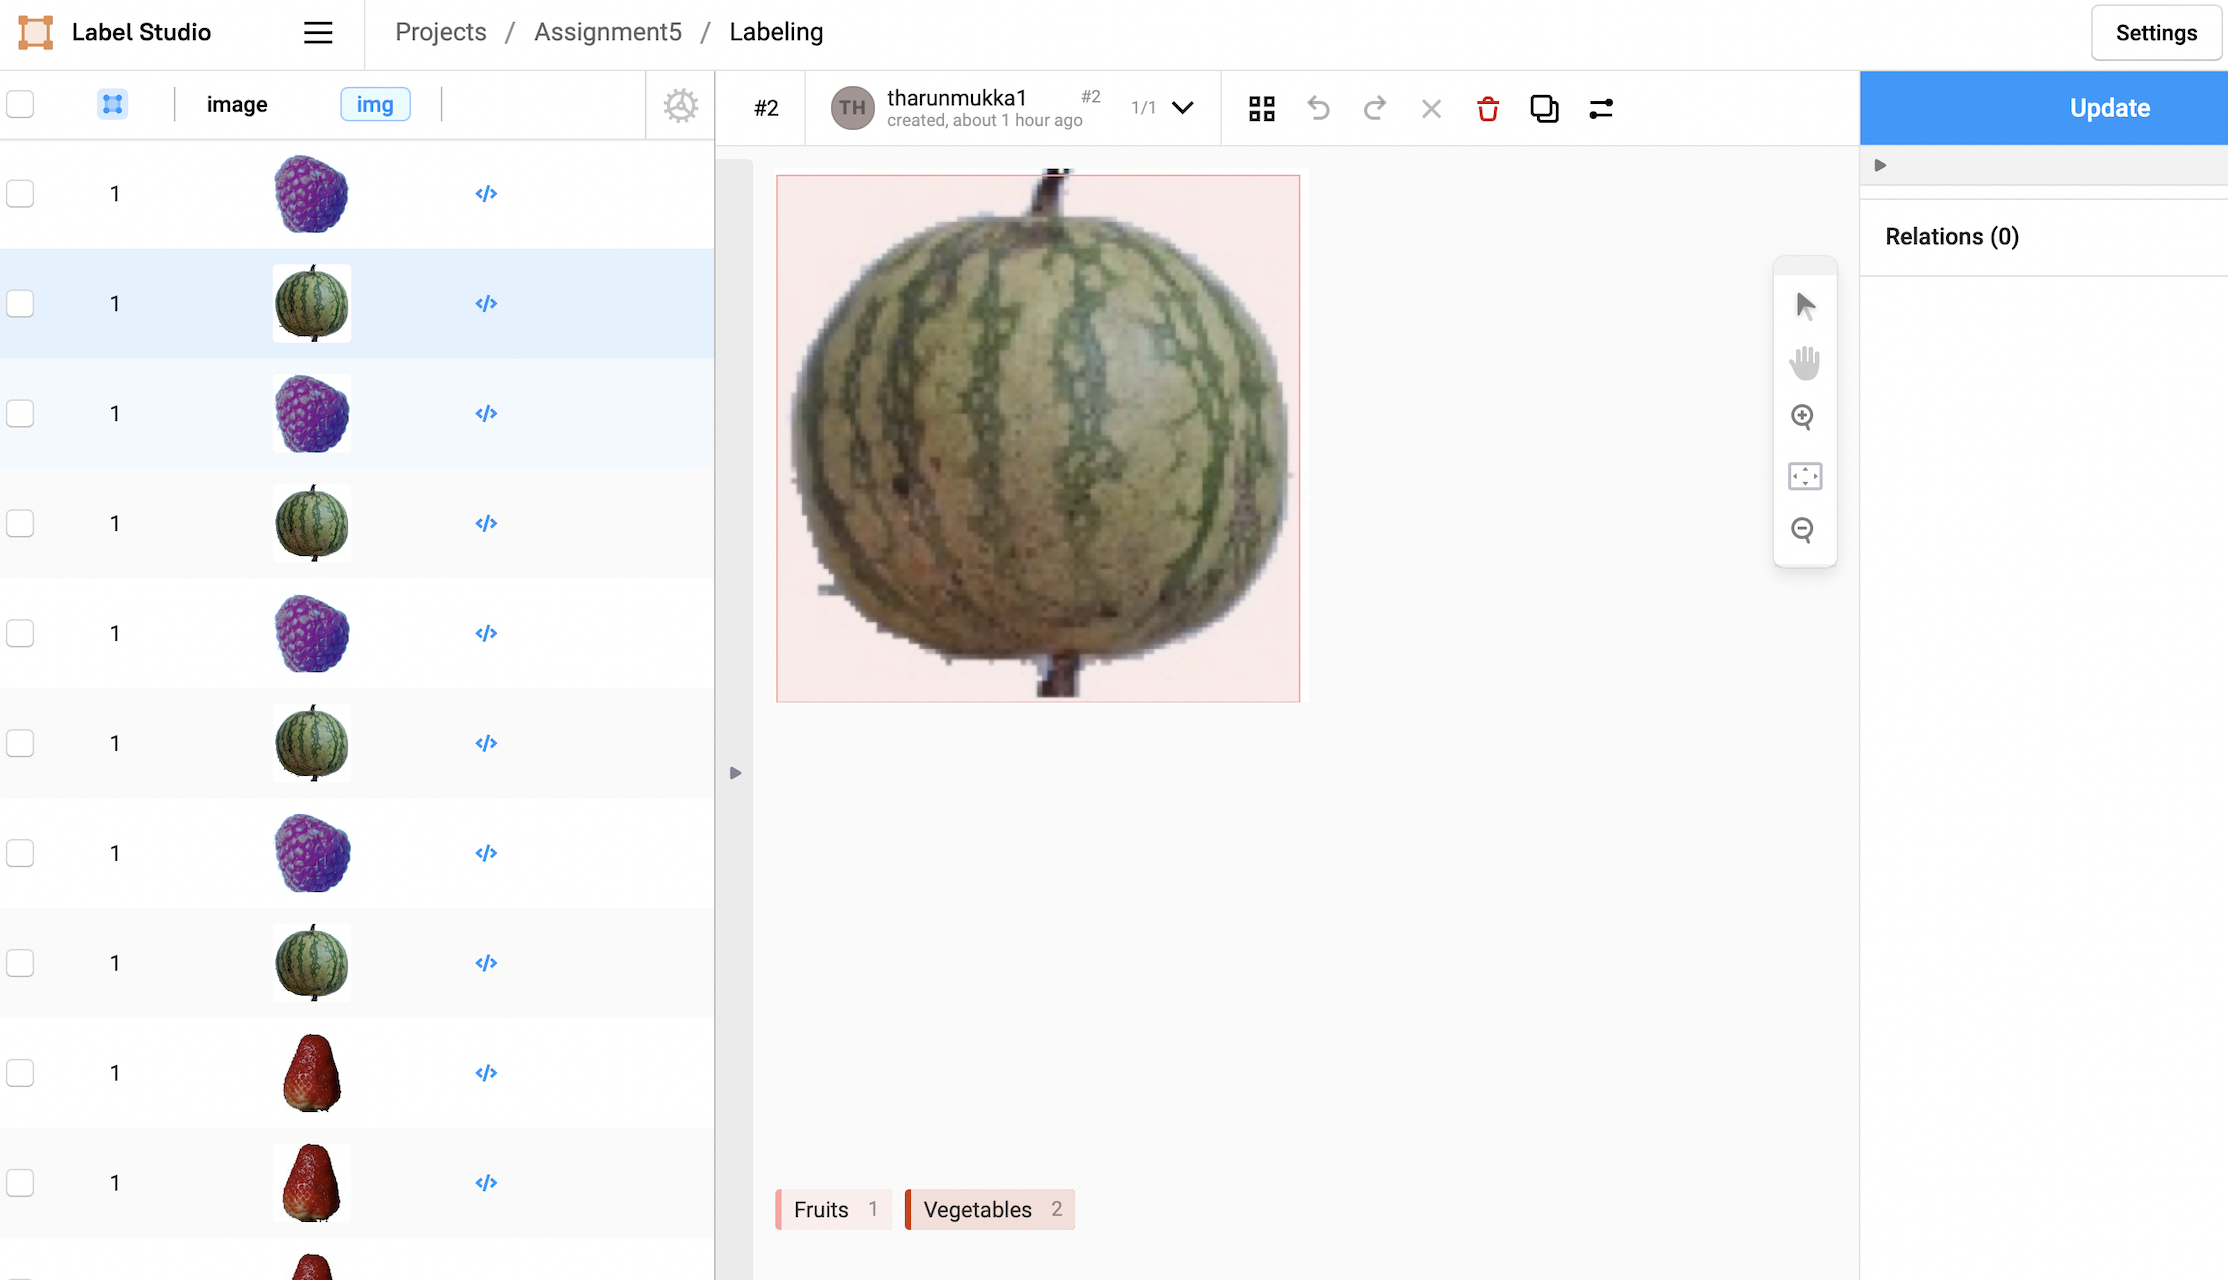

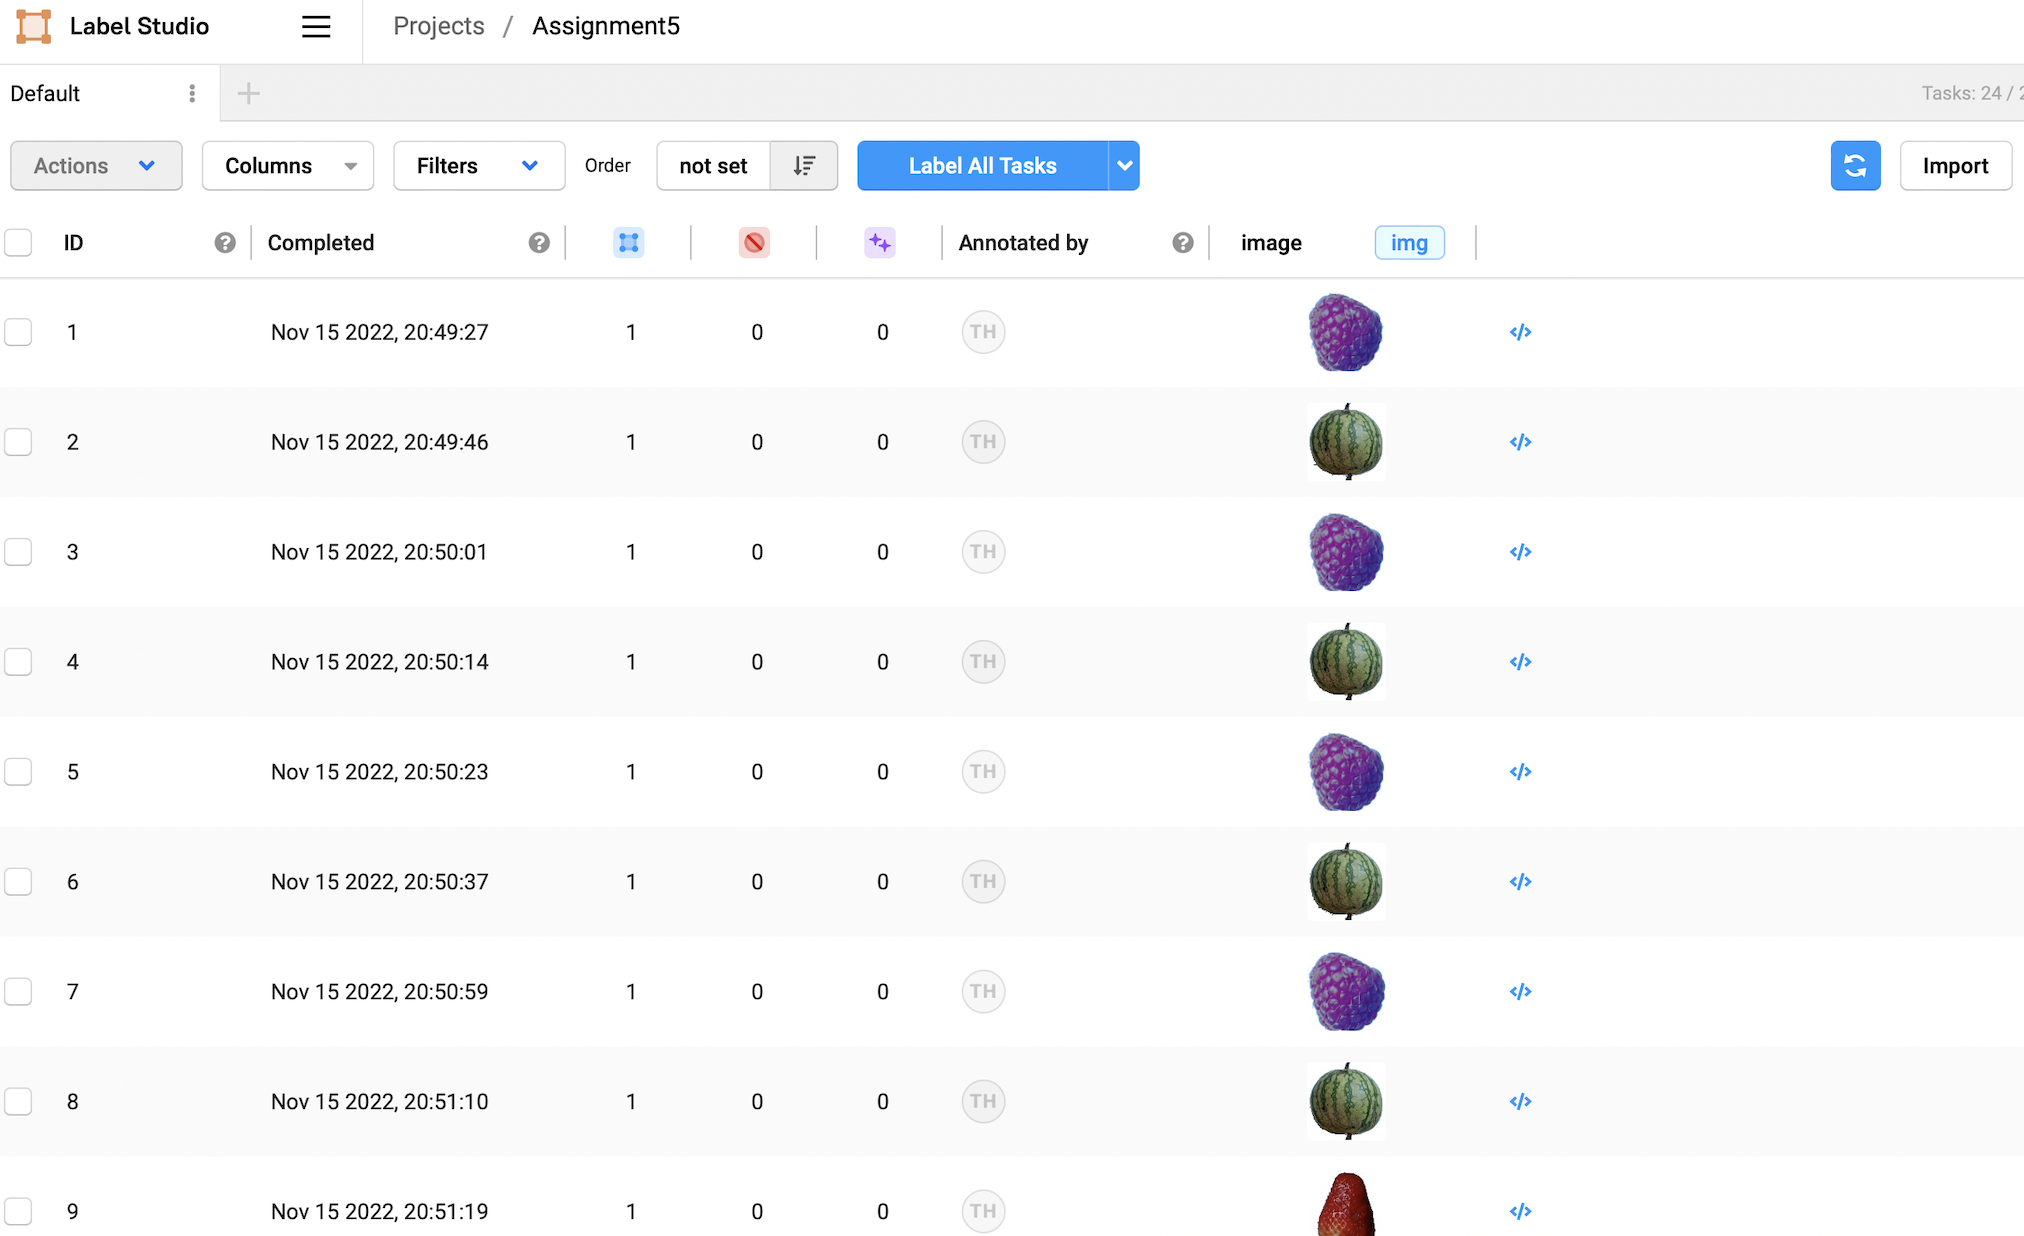

In [ ]:
!lightly-magic token='3188e34d5bc6c77b6b8c58e62c2b3676a68ee5e989e53999' dataset_id='63747a5096ba509f0cd0aa55' input_dir='/content/training_data' trainer.max_epochs=2

/usr/local/lib/python3.7/dist-packages/hydra/_internal/hydra.py:127: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  configure_logging=with_log_configuration,
########## Starting to train an embedding model.
/usr/local/lib/python3.7/dist-packages/lightly/cli/train_cli.py:69: UserWarning: Training a self-supervised model with a small batch size: 16! Small batch size may harm embedding quality. You can specify the batch size via the loader key-word: loader.batch_size=BSZ
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/lightning.py:23: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  "pytorch_lightning.core.lightning.Lig

In [ ]:
import torch
from torchvision import datasets, io, models, ops, transforms, utils

In [ ]:
import json
from typing import Dict, Tuple, List


def read_label_element(label_element: Dict) -> Tuple[str, str]:
    filepath = "/" + label_element["data"]["image"].split("?d=")[-1]
    label = label_element["annotations"][0]["result"][0]["value"]["rectanglelabels"][0]
    return filepath, label

def read_LabelStudio_label_file(filepath: str) -> Tuple[List[str],List[str]]:
    with open(filepath, 'r') as json_file:
        data = json.load(json_file)
    filepaths, labels = zip(* [read_label_element(label_element) for label_element in data])
    return filepaths, labels

In [ ]:
import os
import sys
from typing import List, Tuple, Union

import torch
import torchvision
from lightly.active_learning.scorers import ScorerClassification
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from tqdm import tqdm


class TorchImageDataset(Dataset):
    def __init__(
        self,
        image_paths: List[str],
        label_names: List[str],
        transform: object = None,
        labels: List[str] = None,
    ):
        if transform is None:
            transform = T.Compose(
                [
                    T.Resize((360, 117)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]
            )
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels

        self.label_names = label_names
        self.label_name_to_index = {name: i for i, name in enumerate(label_names)}

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        image_path = self.image_paths[index]
        image_pil = Image.open(image_path).convert("RGB")
        image_torch = self.transform(image_pil)
        if self.labels:
            return image_torch, self.label_name_to_index[self.labels[index]]
        else:
            return image_torch

    def __len__(self):
        return len(self.image_paths)


class ClassificationModel:
    def __init__(
        self, 
        num_classes: int = 3, 
        no_epochs: int = 5, 
        num_workers: int = None,
        batch_size: int = 1,
        **kwargs,
    ):
        self.model = torchvision.models.resnet18(
            pretrained=False, progress=True, num_classes=num_classes
        )
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(self.device)
        self.no_epochs = no_epochs
        self.model_is_trained = False
        self.num_workers = num_workers or min(8, os.cpu_count())
        self.batch_size = batch_size

    def save_on_disk(self, model_path: str = "./classifier.pth"):
        to_save = {"model": self.model.to("cpu"), "label_names": self.label_names}
        torch.save(to_save, model_path)

    def load_from_disk(self, model_path: str = "./classifier.pth"):
        saved_data = torch.load(model_path)
        self.label_names = saved_data["label_names"]
        self.model = saved_data["model"].to(self.device)
        self.model_is_trained = True

    def fit(
        self,
        image_paths: List[str],
        image_labels: List[str],
        label_names: List[str] = None,
    ):
        print("STARTING FITTING")
        if label_names is None:
            self.label_names = sorted(list(set(image_labels)))

        dataset = TorchImageDataset(
            image_paths=image_paths, label_names=self.label_names, labels=image_labels
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=self.num_workers,
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.model.train()
        pbar = tqdm(range(self.no_epochs), file=sys.stdout)
        for epoch in pbar:  
            running_loss = 0.0
            total_samples = 0
            correct = 0
            for data in dataloader:
                inputs, labels = data
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct += (predicted == labels).sum().item()
            text = f"epoch: {epoch} loss: {running_loss / total_samples:.6f} accuracy: {correct/total_samples:.3f}"
            tqdm.write(text)

        self.model_is_trained = True
        print("FINISHED FITTING")

    def predict(self, image_paths: List[str]) -> Tuple[List[str], ScorerClassification]:
        print("STARTING PREDICTION")

        if not self.model_is_trained:
            raise ValueError

        dataset = TorchImageDataset(image_paths, self.label_names)

        dataloader = DataLoader(
            dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
        )
        predictions = []
        self.model.eval()
        with torch.no_grad():
            for x in tqdm(dataloader):
                pred = self.model(x.to(self.device)).cpu()
                predictions.append(pred)

        print("PUTTING TOGETHER RETURN VALUES")

        predictions = [i for sublist in predictions for i in sublist]
        predictions = torch.stack(predictions, dim=0)
        predictions = torch.nn.functional.softmax(predictions, dim=1)

        predicted_classes_int = torch.argmax(predictions, dim=1)
        predicted_classes_str = [self.label_names[i] for i in predicted_classes_int]
        scorer = ScorerClassification(predictions)

        print("FINISHED PREDICTION")

        return predicted_classes_str, scorer

In [ ]:
import os

from lightly.active_learning.agents import ActiveLearningAgent
from lightly.active_learning.config import SelectionConfig
from lightly.api import ApiWorkflowClient
from lightly.data import LightlyDataset
from lightly.openapi_generated.swagger_client import SamplingMethod

if __name__ == "__main__":
    path_full_dataset = "/content/training_data" 
    lighty_webapp_token = "3188e34d5bc6c77b6b8c58e62c2b3676a68ee5e989e53999"
    lighty_webapp_dataset_id = "63747a5096ba509f0cd0aa55"
    api_workflow_client = ApiWorkflowClient(token=lighty_webapp_token, dataset_id=lighty_webapp_dataset_id)
    al_agent = ActiveLearningAgent(api_workflow_client=api_workflow_client)

    filepaths, labels = read_LabelStudio_label_file("/content/updated_labelled.json") ##UPDATE THIS PATH

    classifier = ClassificationModel(no_epochs=20)

    classifier.fit(image_paths=filepaths, image_labels=labels)

    #Predict with the classifier on the complete dataset
    image_filenames_full_dataset = LightlyDataset(path_full_dataset).get_filenames()
    image_paths_full_dataset = [os.path.join(path_full_dataset, filename) for filename in image_filenames_full_dataset]
    predicted_classes_str, scorer = classifier.predict(image_paths=image_paths_full_dataset)

    # Use the active learning sampler "CORAL" via the Lightly API to sample until we have 45 samples
    sampler_config = SelectionConfig(method=SamplingMethod.CORAL, n_samples=45, name="special_assignment")


STARTING FITTING
epoch: 0 loss: 0.811690 accuracy: 0.458
epoch: 1 loss: 1.765664 accuracy: 0.375
epoch: 2 loss: 0.961020 accuracy: 0.625
epoch: 3 loss: 0.967972 accuracy: 0.542
epoch: 4 loss: 1.127668 accuracy: 0.542
epoch: 5 loss: 0.561273 accuracy: 0.708
epoch: 6 loss: 0.480842 accuracy: 0.750
epoch: 7 loss: 0.492746 accuracy: 0.875
epoch: 8 loss: 0.440549 accuracy: 0.750
epoch: 9 loss: 0.464239 accuracy: 0.833
epoch: 10 loss: 0.835674 accuracy: 0.667
epoch: 11 loss: 0.485023 accuracy: 0.833
epoch: 12 loss: 0.311716 accuracy: 0.833
epoch: 13 loss: 0.351937 accuracy: 0.792
epoch: 14 loss: 0.429462 accuracy: 0.875
epoch: 15 loss: 0.554824 accuracy: 0.792
epoch: 16 loss: 0.656399 accuracy: 0.875
epoch: 17 loss: 0.449147 accuracy: 0.708
epoch: 18 loss: 0.607674 accuracy: 0.750
epoch: 19 loss: 0.334218 accuracy: 0.833
100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
FINISHED FITTING
STARTING PREDICTION


100%|██████████| 68/68 [00:00<00:00, 121.19it/s]

PUTTING TOGETHER RETURN VALUES
FINISHED PREDICTION
